###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license © 2014 L.A. Barba, C.D. Cooper, G.F. Forsyth.  Based on [CFD Python](https://github.com/barbagroup/CFDPython), © 2013 L.A. Barba, also under CC-BY license.

# Relax and hold steady

Welcome to the second notebook of *"Relax and hold steady: elliptic problems"*, **Module 5** of the course [**"Practical Numerical Methods with Python"**](https://openedx.seas.gwu.edu/courses/course-v1:MAE+MAE6286+2017/about). Are you relaxed yet?

In the [previous notebook](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/05_relax/05_01_2D.Laplace.Equation.ipynb), you learned to use Jacobi iterations to solve Laplace's equation. The iterations *relax* the solution from an initial guess to the final, steady-state solution. You also saw again that the way we treat boundary conditions can influence our solution. Using a first-order approximation of the Neumann boundary messed up our spatial convergence in the whole domain! (We expected second-order spatial convergence from the central difference scheme, but we got closer to first order.) This was easily fixed by using a second-order scheme for the Neumann boundary. *It's always good to check that you get the expected order of convergence.*

A word of warning: in this course module, we will introduce a different use of the word *"convergence"*. Before, we used it to refer to the decay of the truncation errors (in space and time) with a decrease in the grid spacing ($\Delta x$ and $\Delta t$). Now, we also have a relaxation scheme, and we use the word convergence to mean that the iterative solution approaches the exact solution of the linear system. Sometimes, this is called *algebraic convergence*. We'll concern ourselves with this in the next lesson. But first, let's play with Poisson.

## Poisson equation

The **Poisson equation** has a forcing function that drives the solution to its steady state. Unlike the Laplace equation, Poisson's equation involves imposed values inside the field (a.k.a., sources): 

$$
\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = b
$$

In discretized form, this looks almost the same as [the Laplace Equation](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/05_relax/05_01_2D.Laplace.Equation.ipynb), except for the source term on the right-hand side:

$$
\frac{p_{i+1,j}^{k}-2p_{i,j}^{k}+p_{i-1,j}^{k}}{\Delta x^2}+\frac{p_{i,j+1}^{k}-2 p_{i,j}^{k}+p_{i,j-1}^{k}}{\Delta y^2}=b_{i,j}^{k}
$$

As before, we rearrange this to obtain an equation for $p$ at point $i,j$, based on its neighbors: 

$$
p_{i,j}^{k+1}=\frac{(p_{i+1,j}^{k}+p_{i-1,j}^{k})\Delta y^2+(p_{i,j+1}^{k}+p_{i,j-1}^{k})\Delta x^2-b_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}
$$

It's slightly more complicated than the Laplace equation, but nothing we can't handle.  

### An example problem

Let's consider the following Poisson equation:

$$
\begin{equation}
\nabla^2 p = -2\left(\frac{\pi}{2}\right)^2\sin\left( \frac{\pi x}{L_x} \right) \cos\left(\frac{\pi y}{L_y}\right)
\end{equation}
$$

in the domain 

$$
\left\lbrace \begin{align*}
0 &\leq x\leq 1  \\
-0.5 &\leq y \leq 0.5 
\end{align*} \right.
$$

where $L_x = L_y = 1$ and with Dirichlet boundary conditions 

$$p=0 \text{ at } \left\lbrace 
\begin{align*}
x&=0\\
y&=0\\
y&=-0.5\\
y&=0.5
\end{align*} \right.$$

To solve this equation, we assume an initial state of $p=0$ everywhere, apply the boundary conditions and then iteratively relax the system until we converge on a solution.

To start, let's import the libraries and set up our spatial mesh.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
# Set parameters.
nx = 41  # number of points in the x direction
ny = 41  # number of points in the y direction
xmin, xmax = 0.0, 1.0  # domain limits in the x direction
ymin, ymax = -0.5, 0.5  # domain limits in the y direction
Lx = (xmax - xmin)  # domain length in the x direction
Ly = (ymax - ymin)  # domain length in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction
dy = Ly / (ny - 1)  # grid spacing in the y direction

# Create the gridline locations.
x = numpy.linspace(xmin, xmax, num=nx)
y = numpy.linspace(ymin, ymax, num=ny)

In [4]:
def poisson_source(x, y, Lx, Ly):
    """
    Computes and returns the source term (right-hand side)
    of the Poisson equation.
    
    Parameters
    ----------
    x : numpy.ndarray
        The gridline locations in the x direction
        as a 1D array of floats.
    y : numpy.ndarray
        The gridline locations in the y direction
        as a 1D array of floats.
    Lx : float
        Domain length in the x direction.
    Ly : float
        Domain length in the y direction.
    
    Returns
    -------
    b : numpy.ndarray of floats
        The forcing function as a 2D array.
    """
    X, Y = numpy.meshgrid(x, y)
    b = (-2.0 * numpy.pi / Lx * numpy.pi / Ly *
         numpy.sin(numpy.pi * X / Lx) *
         numpy.cos(numpy.pi * Y / Ly))
    return b

The Jacobi iterations need an exit condition, based on some norm of the difference between two consecutive iterations. We can use the same relative L2-norm that we wrote for the Laplace exit condition, so we saved the function into a helper Python file (`helper.py`) for easy importing.

In [5]:
from helper import l2_norm

Now, what value to choose for the exit condition? We saw in the previous notebook that with an exit tolerance of $10^{-8}$, we could converge well for the different grids we tried, and observe second-order spatial convergence (with the second-order Neumann BC). We speculated in the end that we might be able to use a less stringent exit tolerance, since the spatial error was a lot larger (around $0.0002$ for the finer grid). Here, we'll try with $2\times 10^{-7}$. Go ahead and try with different values and see what you get!

It's time to write the function to solve the Poisson equation.  Notice that all of the boundaries in this problem are Dirichlet boundaries, so no BC updates required!

There's also one extra piece we're adding in here.  To later examine the convergence of the iterative process, we will save the L2-norm of the difference between successive solutions. A plot of this quantity with respect to the iteration number will be an indication of how fast the relaxation scheme is converging.

In [6]:
def poisson_2d_jacobi(p0, b, dx, dy, maxiter=20000, rtol=1e-6):
    """
    Solves the 2D Poisson equation for a given forcing term
    using Jacobi relaxation method.

    The function assumes Dirichlet boundary conditions with value zero.
    The exit criterion of the solver is based on the relative L2-norm
    of the solution difference between two consecutive iterations.

    Parameters
    ----------
    p0 : numpy.ndarray
        The initial solution as a 2D array of floats.
    b : numpy.ndarray
        The forcing term as a 2D array of floats.
    dx : float
        Grid spacing in the x direction.
    dy : float
        Grid spacing in the y direction.
    maxiter : integer, optional
        Maximum number of iterations to perform;
        default: 20000.
    rtol : float, optional
        Relative tolerance for convergence;
        default: 1e-6.

    Returns
    -------
    p : numpy.ndarray
        The solution after relaxation as a 2D array of floats.
    ite : integer
        The number of iterations performed.
    conv : list
        The convergence history as a list of floats.
    """
    p = p0.copy()
    conv = []  # convergence history
    diff = rtol + 1.0  # initial difference
    ite = 0  # iteration index
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, :-2] + pn[1:-1, 2:]) * dy**2 +
                          (pn[:-2, 1:-1] + pn[2:, 1:-1]) * dx**2 -
                          b[1:-1, 1:-1] * dx**2 * dy**2) /
                         (2.0 * (dx**2 + dy**2)))
        # Dirichlet boundary conditions at automatically enforced.
        # Compute and record the relative L2-norm of the difference.
        diff = l2_norm(p, pn)
        conv.append(diff)
        ite += 1
    return p, ite, conv

We can use the `plot_3d` function we wrote in the previous notebook to explore the field $p$, before and after the relaxation. We saved this plotting function into the helper Python file, so we can re-use it here.

In [7]:
from helper import plot_3d

Now we initialize all of the problem variables and plot!

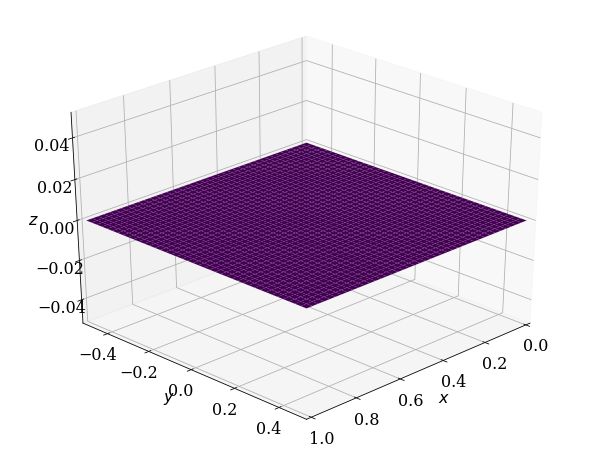

In [8]:
# Set the initial conditions.
p0 = numpy.zeros((ny, nx))

# Compute the source term.
b = poisson_source(x, y, Lx, Ly)

# Plot the initial scalar field.
plot_3d(x, y, p0)

That looks suitably boring. Zeros everywhere and boundaries held at zero. If this were a Laplace problem we would already be done!

But the Poisson problem has a source term that will evolve this zero initial guess to something different. Let's run our relaxation scheme and see what effect the forcing function has on `p`.

In [9]:
# Compute the solution using Jacobi relaxation method.
p, ites, conv = poisson_2d_jacobi(p0, b, dx, dy, rtol=2e-7)
print('Jacobi relaxation: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(conv[-1]))

Jacobi relaxation: 3125 iterations to reach a relative difference of 1.9958631078740742e-07


It took 3,125 iterations to converge to the exit criterion (that's quite a lot, don't you think? Let's now take a look at a plot of the final field:

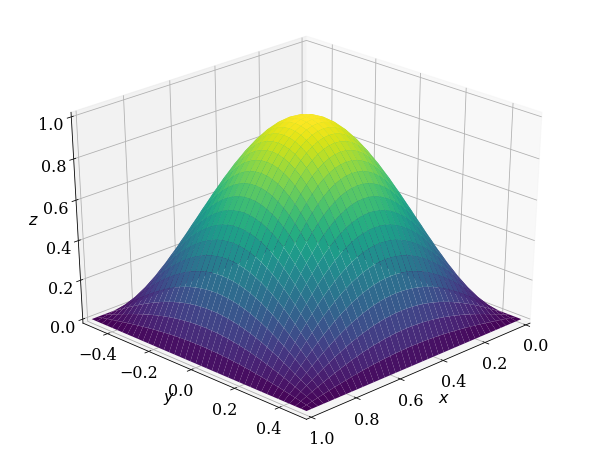

In [10]:
# Plot the solution.
plot_3d(x, y, p)

Something has definitely happened. That looks good, but what about the error? This problem has the following analytical solution:

$$
\begin{equation}
p(x,y) = \sin{\left(\frac{x\pi}{L_x} \right)}\cos{\left(\frac{y\pi}{L_y} \right)}
\end{equation}
$$

Time to compare the calculated solution to the analytical one. Let's do that.

In [11]:
def poisson_solution(x, y, Lx, Ly):
    """
    Computes and returns the analytical solution of the Poisson equation
    on a given two-dimensional Cartesian grid.

    Parameters
    ----------
    x : numpy.ndarray
        The gridline locations in the x direction
        as a 1D array of floats.
    y : numpy.ndarray
        The gridline locations in the y direction
        as a 1D array of floats.
    Lx : float
        Length of the domain in the x direction.
    Ly : float
        Length of the domain in the y direction.

    Returns
    -------
    p : numpy.ndarray
        The analytical solution as a 2D array of floats.
    """
    X, Y = numpy.meshgrid(x, y)
    p = numpy.sin(numpy.pi * X / Lx) * numpy.cos(numpy.pi * Y / Ly)
    return p

In [12]:
# Compute the analytical solution.
p_exact = poisson_solution(x, y, Lx, Ly)

In [13]:
# Compute the relative L2-norm of the error.
l2_norm(p, p_exact)

0.00044962635351970283

That seems small enough. Of course, each application problem can have different accuracy requirements.

### Algebraic convergence

Remember that we saved the L2-norm of the difference between two consecutive iterations. The purpose of that was to look at how the relaxation scheme *converges*, in algebraic sense: with consecutive solutions getting closer and closer to each other. Let's use a line plot for this.

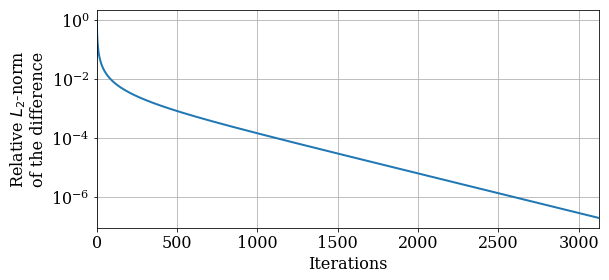

In [14]:
# Plot the convergence history.
pyplot.figure(figsize=(9.0, 4.0))
pyplot.xlabel('Iterations')
pyplot.ylabel('Relative $L_2$-norm\nof the difference')
pyplot.grid()
pyplot.semilogy(conv, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0, len(conv));

It looks like in the beginning, iterations started converging pretty fast, but they quickly adopted a slower rate. As we saw before, it took more than 3,000 iterations to get to our target difference between two consecutive solutions (in L2-norm). That is a *lot* of iterations, and we would really like to relax faster! No worries, we'll learn to do that in the next notebook.

### Spatial convergence

For a sanity check, let's make sure the solution is achieving the expected second-order convergence in space.

In [15]:
# List of the grid sizes to investigate.
nx_values = [11, 21, 41, 81]

# Create an empty list to record the error on each grid.
errors = []

# Compute the solution and error for each grid size.
for nx in nx_values:
    ny = nx  # same number of points in all directions
    dx = Lx / (nx - 1)  # grid spacing in the x direction
    dy = Ly / (ny - 1)  # grid spacing in the y direction
    # Create the gridline locations.
    x = numpy.linspace(xmin, xmax, num=nx)
    y = numpy.linspace(ymin, ymax, num=ny)
    # Set the initial conditions.
    p0 = numpy.zeros((ny, nx))
    # Compute the source term.
    b = poisson_source(x, y, Lx, Ly)
    # Relax the solution.
    # We do not return number of iterations
    # or the convergence history.
    p, ites, _ = poisson_2d_jacobi(p0, b, dx, dy, rtol=2e-7)
    print('[nx = {}] Number of Jacobi iterations: {}'.format(nx, ites))
    # Compute the analytical solution.
    p_exact = poisson_solution(x, y, Lx, Ly)
    # Compute and record the relative L2-norm of the error.
    errors.append(l2_norm(p, p_exact))

[nx = 11] Number of Jacobi iterations: 249
[nx = 21] Number of Jacobi iterations: 892
[nx = 41] Number of Jacobi iterations: 3125
[nx = 81] Number of Jacobi iterations: 10708


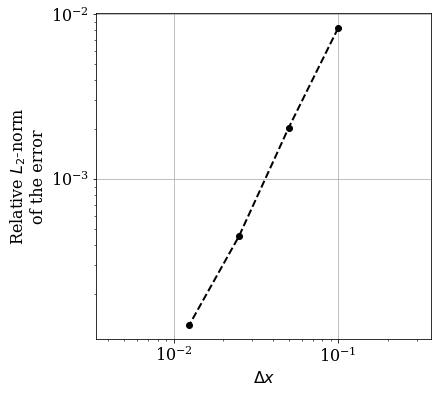

In [16]:
# Plot the error versus the grid-spacing size.
pyplot.figure(figsize=(6.0, 6.0))
pyplot.xlabel(r'$\Delta x$')
pyplot.ylabel('Relative $L_2$-norm\nof the error')
pyplot.grid()
dx_values = Lx / (numpy.array(nx_values) - 1)
pyplot.loglog(dx_values, errors,
              color='black', linestyle='--', linewidth=2, marker='o')
pyplot.axis('equal');

That looks pretty much second order! Remember that the boundary conditions can adversely affect convergence, but Dirichlet boundaries are "exact" and will never impact your convergence.

## Final word

We have used the difference between two consecutive solutions in the iterative process as a way to indicate convergence. However, this is *not* in general the best idea. For some problems and some iterative methods, you could experience iterates *stagnating* but the solution *not converging*.

Convergence of an iterative solution of a system $A \mathbf{x} = \mathbf{b}$ means that:

$$
\begin{equation}
\lim_{k \rightarrow \infty} \mathbf{x}^k = \mathbf{x}
\end{equation}
$$

The error in the solution is actually $\mathbf{x}-\mathbf{x}^k$, but we're looking at $\mathbf{x}^{k+1}-\mathbf{x}^k$ for our exit criterion. They are not the same thing and the second could tend to zero (or machine precision) without the first being comparably small.

A discussion of better ways to apply stopping criteria for iterative methods is a more advanced topic than we want cover in this course module. Just keep this in mind as you continue your exploration of numerical methods in the future!

---
###### The cell below loads the style of the notebook

In [17]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())